<a href="https://colab.research.google.com/github/NikuDubenco/DS-Unit-2-Classification-1/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [28]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.1MB/s 


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.float_format', '{:.2f}'.format)

## Exploring data

In [2]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 19 columns):
game_id                    13958 non-null int64
game_event_id              13958 non-null int64
player_name                13958 non-null object
period                     13958 non-null int64
minutes_remaining          13958 non-null int64
seconds_remaining          13958 non-null int64
action_type                13958 non-null object
shot_type                  13958 non-null object
shot_zone_basic            13958 non-null object
shot_zone_area             13958 non-null object
shot_zone_range            13958 non-null object
shot_distance              13958 non-null int64
loc_x                      13958 non-null int64
loc_y                      13958 non-null int64
shot_made_flag             13958 non-null int64
htm                        13958 non-null object
vtm                        13958 non-null object
season_type                13958 non-null object
s

In [4]:
df.nunique()

game_id                    801
game_event_id              713
player_name                  1
period                       6
minutes_remaining           12
seconds_remaining           60
action_type                 53
shot_type                    2
shot_zone_basic              7
shot_zone_area               6
shot_zone_range              5
shot_distance               73
loc_x                      493
loc_y                      458
shot_made_flag               2
htm                         32
vtm                         32
season_type                  2
scoremargin_before_shot     79
dtype: int64

In [5]:
df.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


In [7]:
df.describe(exclude='number').T

,count,unique,top,freq
player_name,13958,1,Stephen Curry,13958
action_type,13958,53,Jump Shot,6657
shot_type,13958,2,2PT Field Goal,7135
shot_zone_basic,13958,7,Above the Break 3,5695
shot_zone_area,13958,6,Center(C),5987
shot_zone_range,13958,5,24+ ft.,6721
htm,13958,32,GSW,6871
vtm,13958,32,GSW,7087
season_type,13958,2,Regular Season,11846


In [12]:
for feature in df.select_dtypes(exclude='number').columns:
  print(feature, '\n', df[feature].unique(), '\n', '---------' * 10)

player_name 
 ['Stephen Curry'] 
 ------------------------------------------------------------------------------------------
action_type 
 ['Jump Shot' 'Step Back Jump shot' 'Pullup Jump shot' 'Layup Shot'
 'Jump Bank Shot' 'Driving Layup Shot' 'Reverse Layup Shot'
 'Running Jump Shot' 'Floating Jump shot' 'Driving Finger Roll Layup Shot'
 'Running Hook Shot' 'Driving Reverse Layup Shot' 'Turnaround Jump Shot'
 'Fadeaway Jump Shot' 'Running Layup Shot' 'Running Bank shot'
 'Jump Hook Shot' 'Turnaround Bank shot' 'Driving Bank Hook Shot'
 'Running Reverse Layup Shot' 'Tip Shot' 'Fadeaway Bank shot' 'Hook Shot'
 'Pullup Bank shot' 'Finger Roll Layup Shot' 'Slam Dunk Shot'
 'Turnaround Fadeaway shot' 'Driving Dunk Shot' 'Driving Jump shot'
 'Hook Bank Shot' 'Driving Bank shot' 'Running Bank Hook Shot'
 'Putback Layup Shot' 'Dunk Shot' 'Driving Hook Shot'
 'Turnaround Bank Hook Shot' 'Running Finger Roll Layup Shot'
 'Running Slam Dunk Shot' 'Driving Slam Dunk Shot' 'Turnaround Hook Shot'


In [8]:
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.


In [14]:
df.head(3)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0


In [19]:
train = df.loc['2009-10' : '2017-6']
train.shape

(11081, 19)

In [20]:
val = df.loc['2017-10' : '2018-6']
val.shape

(1168, 19)

In [21]:
test = df.loc['2018-10' : '2019-6']
test.shape

(1709, 19)

2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?


In [22]:
# Define the target
target = 'shot_made_flag'

# Put data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

# Shapes new sets
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11081, 18), (11081,), (1168, 18), (1168,))

In [23]:
y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_val_pred = [majority_class] * len(y_val)

In [60]:
# Baseline accuracy for the validation set
accuracy_score(y_val, y_val_pred)

0.5162671232876712

3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

In [32]:
# Check cardinality of categorical features
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
player_name,11081,1,Stephen Curry,11081
shot_type,11081,2,2PT Field Goal,5941
season_type,11081,2,Regular Season,9642
shot_zone_range,11081,5,24+ ft.,5065
shot_zone_area,11081,6,Center(C),4820
shot_zone_basic,11081,7,Above the Break 3,4298
htm,11081,32,GSW,5512
vtm,11081,32,GSW,5569
action_type,11081,51,Jump Shot,5375


In [0]:
# Make pipeline Ordinal Encoding and Random Forest!
pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)


In [87]:
# All features are included
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5916095890410958


#### NOT RUN THIS CELL - not good iteration 

In [84]:
# Include only a few features
features1 = ['action_type', 'game_id', 'game_event_id', 'loc_x', 'loc_y', 
            'seconds_remaining', 'scoremargin_before_shot', 'player_name']

# Make pipeline Ordinal Encoding and Random Forest!
pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))

X_train_1 = train[features1]
X_val_1 = val[features1]

pipeline.fit(X_train_1, y_train)
print('Validation Accuracy', pipeline.score(X_val_1, y_val))

Validation Accuracy 0.5958904109589042


### Iteration that are not good, because test validation result decrease

#### NOT RUN THIS CELL - not good iteration 

In [81]:
# Try other features: excluded 'player_name'
features1 = ['action_type', 'game_id', 'game_event_id', 'loc_x', 'loc_y', 
            'seconds_remaining', 'scoremargin_before_shot']

# Make pipeline Ordinal Encoding and Random Forest!
pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=600, random_state=42, n_jobs=-1))

X_train_1 = train[features1]
X_val_1 = val[features1]

pipeline.fit(X_train_1, y_train)
print('Validation Accuracy', pipeline.score(X_val_1, y_val))

Validation Accuracy 0.6044520547945206


#### NOT RUN THIS CELL - not good iteration 

In [80]:
# Try other features: excluded 'player_name'
features1 = ['action_type', 'game_id', 'game_event_id', 'loc_x', 'loc_y', 
            'seconds_remaining', 'scoremargin_before_shot', 'shot_distance']

# Make pipeline Ordinal Encoding and Random Forest!
pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))

X_train_1 = train[features1]
X_val_1 = val[features1]

pipeline.fit(X_train_1, y_train)
print('Validation Accuracy', pipeline.score(X_val_1, y_val))

Validation Accuracy 0.5847602739726028


2. Get your model's **test accuracy.** (One time, at the end.)


In [0]:
# Put test dataset into X features matrix and y target vector
y_test = test[target]
X_test = test.drop(columns=target)

In [88]:
# Do prediction
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.6167349327091867


3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**


In [0]:
# Get feature importances
encoder = pipeline.named_steps['ordinalencoder']
r_forest = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_train).columns
importances = pd.Series(r_forest.feature_importances_, feature_names)

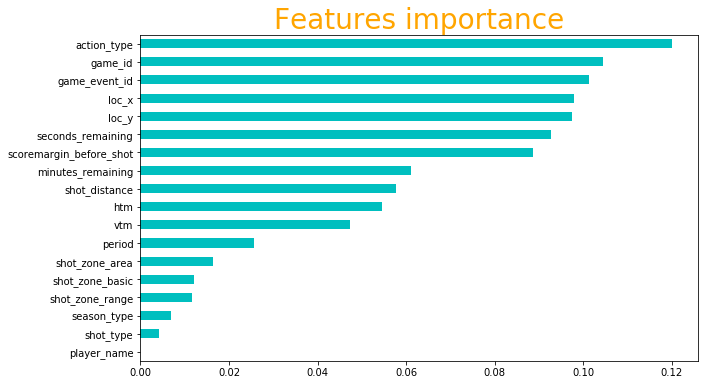

In [52]:
# Plot feature importances
n = 18
plt.figure(figsize=(10,6))
plt.title('Features importance', fontsize=28, color='orange')
importances.sort_values()[-n:].plot.barh(color='c');

4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

In [13]:
# Calculate accuracy negative
accuracy = (85 + 36) / (85 + 57 + 8 + 36)
print('accuracy =', accuracy)

# Precision of negative
precision = 85 / (85 + 8)
print('precision =', precision)

# Recall of negative
recall = 85 / (85 + 58)
print('recall =', recall)

accuracy = 0.6505376344086021
precision = 0.9139784946236559
recall = 0.5944055944055944
